In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from google.colab import files

# Create a Spark session
spark = SparkSession.builder \
    .appName("Dataset Upload") \
    .getOrCreate()

# Upload the dataset (Google Colab example)
uploaded = files.upload()
file_path = list(uploaded.keys())[0] # Get the name of the uploaded file

# Load the dataset into a Spark DataFrame
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .csv(file_path)

# Show the first few rows of the DataFrame
df.show(5)

# Print the schema
df.printSchema()

Saving Jobs_NYC_Postings.csv to Jobs_NYC_Postings.csv
+------+--------------------+--------------+--------------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+--------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+-----------+--------------------+-------------------+------------+----------+---------------+------------+
|Job ID|              Agency|# Of Positions|      Business Title| Civil Service Title|Title Classification|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|        Career Level|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Hours/Shift|     Work Location 1|Recruitment Contact|Posting Date|Post Until|Posting Updated|Process Date|
+------+----

**Descriptive Analysis**
* Descriptive Analysis
* Number of columns and rows
* Percent of missing values by columns
* Means, medians, modes, correlations, variance, outliers
* Data visualizations such as scatter plots or correlation plots

In [4]:
#1 Number of Columns and Rows
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 5346
Number of Columns: 26


In [5]:
#2 Percent of Missing Values by Columns
from pyspark.sql.functions import count, when, col, isnan # Importing necessary functions
missing_percentage = df.select([(count(when(col(c).isNull() | isnan(c), c)) / num_rows).alias(c) for c in df.columns])
missing_percentage.show()

+------+------+--------------+--------------+-------------------+--------------------+-------------+-----+------------+-----------------------------+------------+-----------------+---------------+----------------+-------------+------------------+--------------------+-------------------------+------------------+------------------+------------------+-------------------+------------+------------------+---------------+------------+
|Job ID|Agency|# Of Positions|Business Title|Civil Service Title|Title Classification|Title Code No|Level|Job Category|Full-Time/Part-Time indicator|Career Level|Salary Range From|Salary Range To|Salary Frequency|Work Location|Division/Work Unit|     Job Description|Minimum Qual Requirements|  Preferred Skills|       Hours/Shift|   Work Location 1|Recruitment Contact|Posting Date|        Post Until|Posting Updated|Process Date|
+------+------+--------------+--------------+-------------------+--------------------+-------------+-----+------------+-----------------

                     Job ID  # Of Positions  Salary Range From  \
Job ID             1.000000       -0.031777           0.091605   
# Of Positions    -0.031777        1.000000          -0.103119   
Salary Range From  0.091605       -0.103119           1.000000   
Salary Range To    0.006735       -0.100001           0.767764   

                   Salary Range To  
Job ID                    0.006735  
# Of Positions           -0.100001  
Salary Range From         0.767764  
Salary Range To           1.000000  


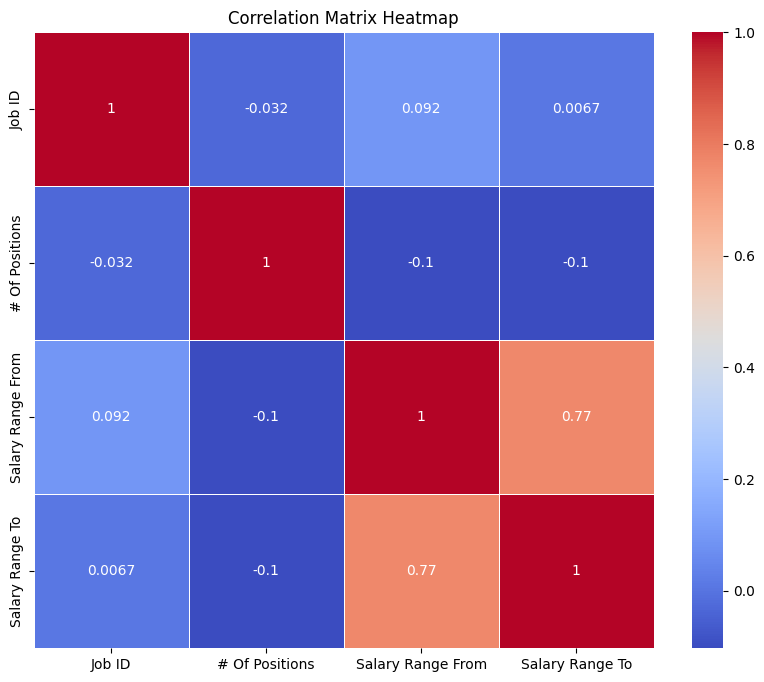

In [6]:
#3 Correlation ma
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get numeric columns
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double')]

# Compute Correlations
correlations = []
for col1 in numeric_columns:
    row = []
    for col2 in numeric_columns:
        corr_value = df.stat.corr(col1, col2)
        row.append(corr_value)
    correlations.append(row)

# Convert to Pandas DataFrame for easy visualization
corr_matrix_df = pd.DataFrame(correlations, index=numeric_columns, columns=numeric_columns)

# Display Correlation Matrix
print(corr_matrix_df)

# Plot the Correlation Matrix as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [9]:
#4 Variance
from pyspark.sql.functions import stddev, col # Importing necessary functions, including stddev

variances = df.select([stddev(col(c))**2 for c in numeric_columns])
variances.show()

+------------------------+--------------------------------+-----------------------------------+---------------------------------+
|POWER(stddev(Job ID), 2)|POWER(stddev(# Of Positions), 2)|POWER(stddev(Salary Range From), 2)|POWER(stddev(Salary Range To), 2)|
+------------------------+--------------------------------+-----------------------------------+---------------------------------+
|     1.395087026349331E9|               27.25748175725308|               1.0017329389635355E9|             2.3099420723383493E9|
+------------------------+--------------------------------+-----------------------------------+---------------------------------+



In [10]:
#5 Outlier Detection using IQR
bounds = {}
for col_name in numeric_columns:
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    IQR = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - 1.5 * IQR
    upper_bound = quantiles[1] + 1.5 * IQR
    bounds[col_name] = (lower_bound, upper_bound)

# Count outliers
outliers = {}
for col_name in numeric_columns:
    lb, ub = bounds[col_name]
    outliers[col_name] = df.filter((col(col_name) < lb) | (col(col_name) > ub)).count()

print("Outliers by Column:")
for col_name, outlier_count in outliers.items():
    print(f"{col_name}: {outlier_count} outliers")

Outliers by Column:
Job ID: 461 outliers
# Of Positions: 1066 outliers
Salary Range From: 608 outliers
Salary Range To: 279 outliers


**Exploratory Data Analysis (EDA)**

Understanding its structure and derive insights.
* Column Analysis: Check for null values and data types.
* Descriptive Statistics: Analyze columns like # Of Positions, Salary Range From, and Salary Range To.

In [11]:
# Drop rows with null values in crucial columns
df = df.na.drop(subset=["Job ID", "Agency", "Salary Range From", "Salary Range To"])

# Filter out jobs where salary is zero or negative
df = df.filter((col("Salary Range From") > 0) & (col("Salary Range To") > 0))

df.show(5)

+------+--------------------+--------------+--------------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+--------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+-----------+--------------------+-------------------+------------+----------+---------------+------------+
|Job ID|              Agency|# Of Positions|      Business Title| Civil Service Title|Title Classification|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|        Career Level|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Hours/Shift|     Work Location 1|Recruitment Contact|Posting Date|Post Until|Posting Updated|Process Date|
+------+--------------------+--------------+--------------------+-

In [12]:
#3 Descriptive Statistics (Mean, Median, Mode, Variance)
from pyspark.sql.types import NumericType  # Import NumericType for type checking

numerical_df = df.select([c for c in df.columns if isinstance(df.schema[c].dataType, NumericType)])
numerical_df.describe().show()

# Median (approximate) for numerical columns only
medians = numerical_df.approxQuantile(numerical_df.columns, [0.5], 0.01)  # [0.5] for median
print(f"Medians: {medians}")

+-------+-----------------+------------------+------------------+------------------+
|summary|           Job ID|    # Of Positions| Salary Range From|   Salary Range To|
+-------+-----------------+------------------+------------------+------------------+
|  count|             5336|              5336|              5336|              5336|
|   mean|626343.6669790104|1.9799475262368815| 66907.03696304349| 92263.63681465521|
| stddev|37293.93629061685| 5.224856861136402|31547.351474514348|48010.891231886955|
|    min|           469953|                 1|              15.0|             15.45|
|    max|           683325|               110|          300000.0|          334000.0|
+-------+-----------------+------------------+------------------+------------------+

Medians: [[634059.0], [1.0], [64142.0], [85147.0]]


**Data Preprocessing**

* Variable treatment
* Dropping columns and rows when necessary
* Imputing missing values
* Transforming variables if necessary

In [13]:
# Drop rows with null values in crucial columns
df = df.na.drop(subset=["Job ID", "Agency", "Salary Range From", "Salary Range To"])

# Filter out jobs where salary is zero or negative
df = df.filter((col("Salary Range From") > 0) & (col("Salary Range To") > 0))

**Data Transformation**

Transform the data for better analysis or to create new features.

* Calculate Average Salary: Create a new column to calculate the average salary.
* Group Jobs by Category: Group jobs by Job Category to see how many jobs are available per category.

In [14]:
# Create a new column for average salary

from pyspark.sql.functions import col, lit, concat
df = df.withColumn("Average Salary", concat(lit("$"), ((col("Salary Range From") + col("Salary Range To")) / 2)))
df.select("Job Category", "Average Salary").show(10)

+--------------------+--------------+
|        Job Category|Average Salary|
+--------------------+--------------+
|Engineering, Arch...|     $144346.0|
|Health Technology...|      $90172.5|
|Green Jobs Public...|      $60536.5|
|Engineering, Arch...|      $96626.0|
|Constituent Servi...|      $45008.5|
|Building Operatio...|      $87701.0|
|       Legal Affairs|     $100053.0|
|Technology, Data ...|      $66314.5|
|Constituent Servi...|      $70087.0|
|Constituent Servi...|        $25.86|
+--------------------+--------------+
only showing top 10 rows



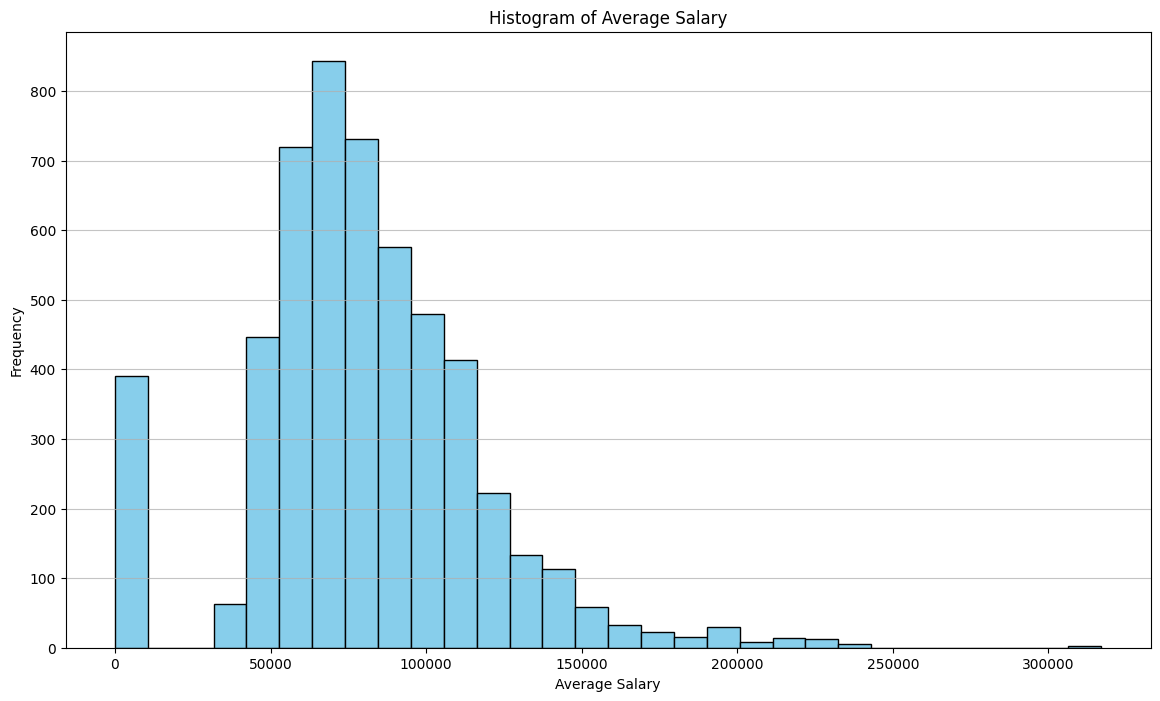

In [15]:
# Step 1: Convert necessary columns to Pandas DataFrame
pandas_df = df.select("Salary Range From", "Salary Range To").toPandas()

# Step 2: Calculate Average Salary
pandas_df["Average Salary"] = (pandas_df["Salary Range From"] + pandas_df["Salary Range To"]) / 2

# Step 3: Create a histogram for Average Salary
plt.figure(figsize=(14, 8))
plt.hist(pandas_df["Average Salary"], bins=30, color='skyblue', edgecolor='black')

# Set labels and title
plt.xlabel("Average Salary")
plt.ylabel("Frequency")
plt.title("Histogram of Average Salary")

# Show plot
plt.grid(axis='y', alpha=0.75)
plt.show()

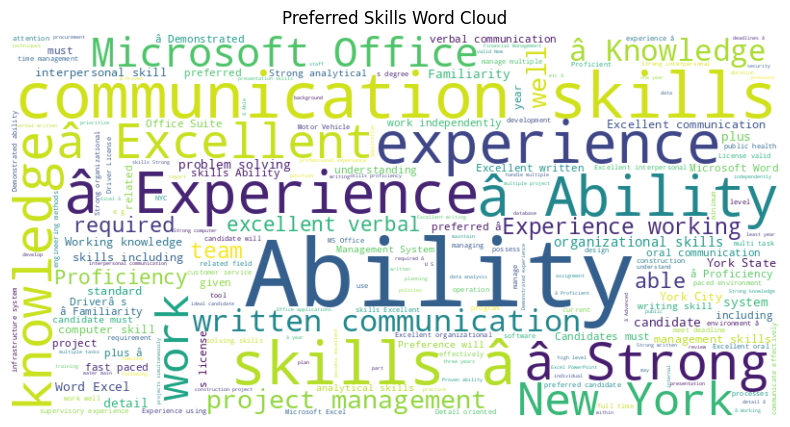

In [16]:
# Import wordcloud library
from wordcloud import WordCloud

# Step 1: Convert necessary columns to Pandas DataFrame
pandas_df = df.select("Preferred Skills").toPandas()

# Step 2: Combine all text into a single string
text = " ".join(skill for skill in pandas_df["Preferred Skills"] if skill is not None)

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Step 4: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Preferred Skills Word Cloud")

# Show plot
plt.show()

<ipython-input-17-6201fc3ca423>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pandas_df["Posting Date"] = pd.to_datetime(pandas_df["Posting Date"])


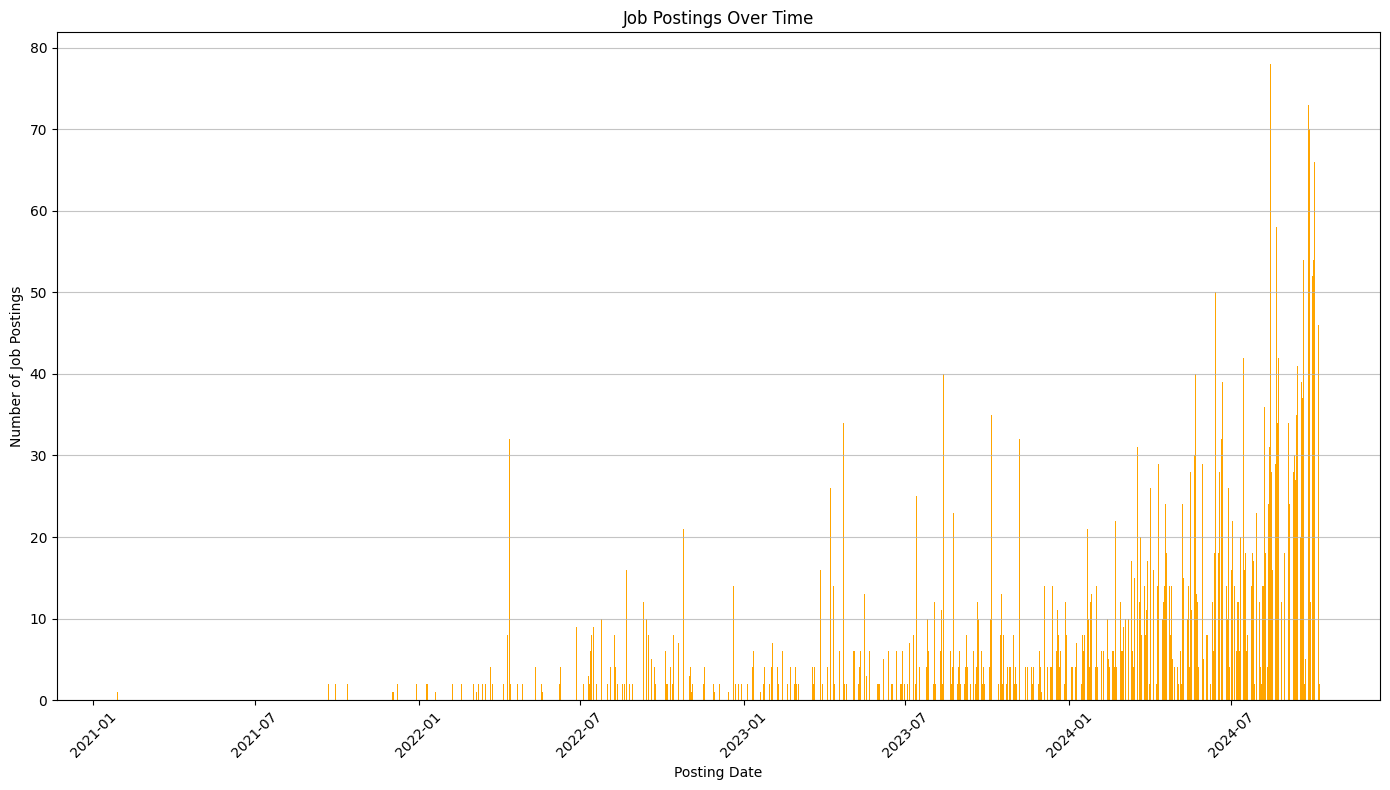

In [17]:
# Step 1: Convert necessary columns to Pandas DataFrame
pandas_df = df.select("Posting Date").toPandas()

# Convert Posting Date to datetime format
pandas_df["Posting Date"] = pd.to_datetime(pandas_df["Posting Date"])

# Step 2: Group by Posting Date and count the number of job postings per day
posting_counts = pandas_df.groupby("Posting Date").size().reset_index(name="Count")

# Step 3: Create a bar plot
plt.figure(figsize=(14, 8))
plt.bar(posting_counts["Posting Date"], posting_counts["Count"], color='orange')

# Set labels and title
plt.xlabel("Posting Date")
plt.ylabel("Number of Job Postings")
plt.title("Job Postings Over Time")

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

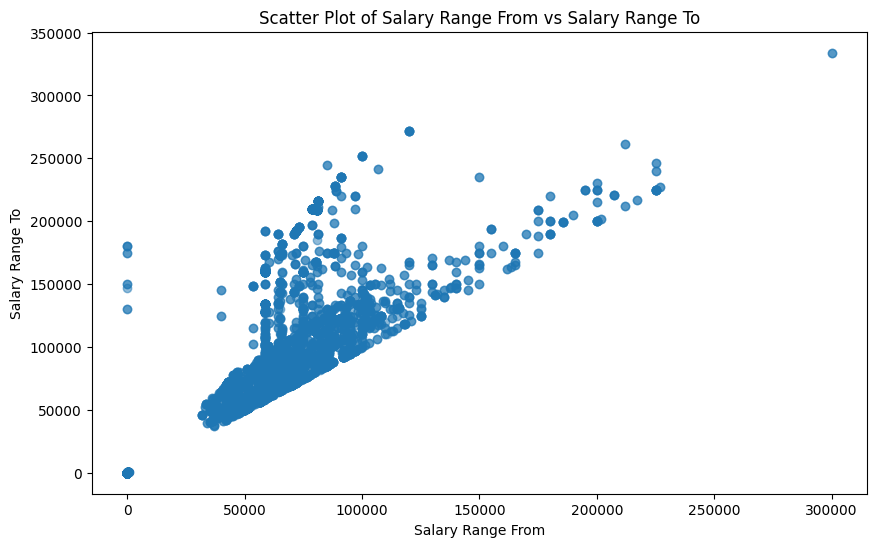

In [8]:
# Step 1: Convert necessary columns to Pandas DataFrame
pandas_df = df.select("Salary Range From", "Salary Range To").toPandas()

# Step 2: Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["Salary Range From"], pandas_df["Salary Range To"], alpha=0.5)

# Set labels and title
plt.xlabel("Salary Range From")
plt.ylabel("Salary Range To")
plt.title("Scatter Plot of Salary Range From vs Salary Range To")

# Show plot
plt.show()

**Insights Extraction**
Extract useful insights from the dataset.

* **Top Agencies by Number of Jobs:** Identify which agencies have the most job postings.
* **Most Common Job Titles** Find the most frequent job titles.
* **Highest Paying Job Titles:** Identify jobs with the highest average salaries.

In [18]:
# Group jobs by category and count the number of jobs in each
job_counts = df.groupBy("Job Category").count().orderBy("count", ascending=False)
job_counts.show(10)

+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  920|
|              Health|  348|
|Technology, Data ...|  289|
|       Legal Affairs|  275|
|Finance, Accounti...|  270|
|     Social Services|  262|
|Administration & ...|  254|
|Engineering, Arch...|  246|
|Building Operatio...|  238|
|Public Safety, In...|  204|
+--------------------+-----+
only showing top 10 rows



In [19]:
# Top agencies by number of job postings
top_agencies = df.groupBy("Agency").count().orderBy("count", ascending=False)
top_agencies.show(10)

+--------------------+-----+
|              Agency|count|
+--------------------+-----+
|DEPT OF ENVIRONME...| 1069|
|DEPT OF HEALTH/ME...|  863|
|HRA/DEPT OF SOCIA...|  587|
|DEPT OF DESIGN & ...|  546|
|DEPARTMENT OF TRA...|  518|
|NYC HOUSING AUTHO...|  251|
|BRONX DISTRICT AT...|  174|
|HOUSING PRESERVAT...|  128|
|DEPARTMENT OF COR...|  123|
|ADMIN FOR CHILDRE...|   75|
+--------------------+-----+
only showing top 10 rows



In [20]:
# Most common job titles
common_titles = df.groupBy("Business Title").count().orderBy("count", ascending=False)
common_titles.show(10)

+--------------------+-----+
|      Business Title|count|
+--------------------+-----+
|     Deputy Director|   58|
|     Project Manager|   56|
| ACCOUNTABLE MANAGER|   54|
|ASSISTANT PROJECT...|   52|
|DEPUTY PORTFOLIO ...|   40|
|  Engineer-In-Charge|   38|
|Senior Project Ma...|   36|
|        College Aide|   34|
|CASE MANAGEMENT S...|   32|
|Assistant General...|   26|
+--------------------+-----+
only showing top 10 rows



In [21]:
# Highest paying jobs
highest_paying_jobs = df.orderBy("Average Salary", ascending=False).select("Business Title", "Average Salary", "Agency")
highest_paying_jobs.show(10)

+--------------------+--------------+--------------------+
|      Business Title|Average Salary|              Agency|
+--------------------+--------------+--------------------+
|      CHIEF OF STAFF|      $99857.5|HRA/DEPT OF SOCIA...|
|      CHIEF OF STAFF|      $99857.5|HRA/DEPT OF SOCIA...|
|Policy and Proced...|      $99571.0|DEPT OF HEALTH/ME...|
|Senior Director o...|      $99571.0|DEPT OF HEALTH/ME...|
|Senior Director o...|      $99571.0|DEPT OF HEALTH/ME...|
|Policy and Proced...|      $99571.0|DEPT OF HEALTH/ME...|
|Emergency Managem...|      $99514.5|DEPT OF ENVIRONME...|
|Emergency Managem...|      $99514.5|DEPT OF ENVIRONME...|
|       Data Engineer|      $99503.0|BRONX DISTRICT AT...|
|       Data Engineer|      $99503.0|BRONX DISTRICT AT...|
+--------------------+--------------+--------------------+
only showing top 10 rows



**Fitting models**

* Summarize performance indicators of models
* Summarize model


**Classification Model - Random Forest**

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("CareerLevelRandomForest").getOrCreate()

In [23]:
string_indexer_agency = StringIndexer(inputCol="Agency", outputCol="Agency_Index")
string_indexer_job_category = StringIndexer(inputCol="Job Category", outputCol="Job_Category_Index")
string_indexer_career_level = StringIndexer(inputCol="Career Level", outputCol="Career_Level_Index")


In [24]:
# Step 2: One Hot Encoding for indexed categorical features
one_hot_encoder_agency = OneHotEncoder(inputCols=["Agency_Index"], outputCols=["Agency_OHE"])
one_hot_encoder_job_category = OneHotEncoder(inputCols=["Job_Category_Index"], outputCols=["Job_Category_OHE"])


In [25]:
# Step 3: Assemble features into a single vector
vector_assembler = VectorAssembler(
    inputCols=["Agency_OHE", "Job_Category_OHE", "Salary Range From", "Salary Range To"],
    outputCol="features"
)


In [26]:
# Step 4: Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(labelCol="Career_Level_Index", featuresCol="features")

# Step 5: Create a pipeline
pipeline = Pipeline(stages=[
    string_indexer_agency,
    string_indexer_job_category,
    string_indexer_career_level,
    one_hot_encoder_agency,
    one_hot_encoder_job_category,
    vector_assembler,
    rf_classifier
])

In [27]:
# Step 6: Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [28]:
model = pipeline.fit(train_df)

In [29]:
predictions = model.transform(test_df)

In [30]:
predictions.select("Business Title", "Career Level", "prediction").show()

+--------------------+--------------------+----------+
|      Business Title|        Career Level|prediction|
+--------------------+--------------------+----------+
|Child Protective ...|Experienced (non-...|       0.0|
|          UNIT CLERK|Experienced (non-...|       0.0|
| Project Coordinator|Experienced (non-...|       0.0|
|  PAYMENT SPECIALIST|Experienced (non-...|       0.0|
|Child Protective ...|Experienced (non-...|       0.0|
|ADMINISTRATIVE AC...|Experienced (non-...|       0.0|
|Assistant General...|Experienced (non-...|       0.0|
|Child Protective ...|             Manager|       0.0|
|Supervisor Electr...|Experienced (non-...|       0.0|
|         Electrician|Experienced (non-...|       0.0|
|         Electrician|Experienced (non-...|       0.0|
|             Plumber|Experienced (non-...|       0.0|
|           PLASTERER|         Entry-Level|       0.0|
|Electrician's Helper|Experienced (non-...|       0.0|
|         ELECTRICIAN|Experienced (non-...|       0.0|
|Recreatio

In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [32]:
indexer = StringIndexer(inputCol="Career Level", outputCol="Career_Level_Index", handleInvalid="keep")

In [33]:
pipeline = Pipeline(stages=[indexer, ...])

In [34]:
spark = SparkSession.builder.appName("CareerLevelRandomForest").getOrCreate()

# Assuming 'df' is your DataFrame loaded with the required data

# Step 1: Index categorical features with handleInvalid set to "keep"
string_indexer_agency = StringIndexer(inputCol="Agency", outputCol="Agency_Index", handleInvalid="keep")
string_indexer_job_category = StringIndexer(inputCol="Job Category", outputCol="Job_Category_Index", handleInvalid="keep")
string_indexer_career_level = StringIndexer(inputCol="Career Level", outputCol="Career_Level_Index", handleInvalid="keep")

# Step 2: One Hot Encoding for indexed categorical features
one_hot_encoder_agency = OneHotEncoder(inputCols=["Agency_Index"], outputCols=["Agency_OHE"])
one_hot_encoder_job_category = OneHotEncoder(inputCols=["Job_Category_Index"], outputCols=["Job_Category_OHE"])

# Step 3: Assemble features into a single vector
vector_assembler = VectorAssembler(
    inputCols=["Agency_OHE", "Job_Category_OHE", "Salary Range From", "Salary Range To"],
    outputCol="features"
)

# Step 4: Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(labelCol="Career_Level_Index", featuresCol="features")

# Step 5: Create a pipeline
pipeline = Pipeline(stages=[
    string_indexer_agency,
    string_indexer_job_category,
    string_indexer_career_level,
    one_hot_encoder_agency,
    one_hot_encoder_job_category,
    vector_assembler,
    rf_classifier
])

# Step 6: Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Fit the model
model = pipeline.fit(train_df)

# Step 8: Make predictions on the test set
predictions = model.transform(test_df)

# Step 9: Show predictions
predictions.select("Business Title", "Career Level", "prediction").show()

# Step 10: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Career_Level_Index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the Random Forest model: {accuracy:.2f}")

+--------------------+--------------------+----------+
|      Business Title|        Career Level|prediction|
+--------------------+--------------------+----------+
|Child Protective ...|Experienced (non-...|       0.0|
|          UNIT CLERK|Experienced (non-...|       0.0|
| Project Coordinator|Experienced (non-...|       0.0|
|  PAYMENT SPECIALIST|Experienced (non-...|       0.0|
|Child Protective ...|Experienced (non-...|       0.0|
|ADMINISTRATIVE AC...|Experienced (non-...|       0.0|
|Assistant General...|Experienced (non-...|       0.0|
|Child Protective ...|             Manager|       0.0|
|Supervisor Electr...|Experienced (non-...|       0.0|
|         Electrician|Experienced (non-...|       0.0|
|         Electrician|Experienced (non-...|       0.0|
|             Plumber|Experienced (non-...|       0.0|
|           PLASTERER|         Entry-Level|       0.0|
|Electrician's Helper|Experienced (non-...|       0.0|
|         ELECTRICIAN|Experienced (non-...|       0.0|
|Recreatio

In [35]:
# Summarize performance indicators of models
# Summarize model

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Career_Level_Index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the Random Forest model: {accuracy:.2f}")

# Additional Evaluation Metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Career_Level_Index", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score of the Random Forest model: {f1_score:.2f}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="Career_Level_Index", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision of the Random Forest model: {precision:.2f}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Career_Level_Index", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall of the Random Forest model: {recall:.2f}")

# Model Summary
print("\nRandom Forest Model Summary:")
print("---------------------------")
print(f"Number of Trees: {model.stages[-1].getNumTrees}")
print(f"Max Depth: {model.stages[-1].getMaxDepth()}")

Accuracy of the Random Forest model: 0.76
F1-Score of the Random Forest model: 0.66
Precision of the Random Forest model: 0.58
Recall of the Random Forest model: 0.76

Random Forest Model Summary:
---------------------------
Number of Trees: 20
Max Depth: 5
